# Convert ERA5 variable units to the values expected by NEMO

Variables read in by NEMO: sn_wndi (uas), sn_wndj (vas), sn_qsr (rsds), sn_qlw (rlds), sn_tair (tas), sn_humi (huss), sn_prec (tprecip), sn_snow (prsn), sn_slp (psl).

Variable conversions needed:
- U wind ERA5 --> eastward near surface wind (which then is rotated to the NEMO grid U and V online)
- V wind ERA5 --> northward near surface wind
- Humidity: convert 2 m dewpoint temperature --> near surface specific humidity

Unit conversions needed:
- snowfall flux: m of water equivalent --> kg /m2 /s
- total solid + liquid precip: m --> kg /m2 /s
- surface downwelling LW radiation: J/m2 --> W/m2
- surface downwelling SW radiation: J/m2 --> W/m2

In [1]:
import numpy as np
import xarray as xr
import glob

#### Functions

In [16]:
def convert_wind(file_U='era5_u10_1979_daily_averages.nc', variableU='u10',
                 file_V='era5_v10_1979_daily_averages.nc', variableV='v10',
                 dataset='ERA5', folder='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/ERA5-forcing/'):
    # ERA5 gives wind in U and V grid direction instead of eastward and northward
    # https://confluence.ecmwf.int/pages/viewpage.action?pageId=133262398
    
    Uwind = xr.open_dataset(f'{folder}{file_U}')[variableU]
    Vwind = xr.open_dataset(f'{folder}{file_V}')[variableV]

    speed = np.sqrt(Uwind**2 + Vwind**2)

    theta = 90 # eastward or 0 for northerly
    u_dir = - speed * np.sin(theta)
    v_dir = - speed * np.cos(theta)
                     
    return u_dir, v_dir

# Function to convert the units of shortwave and longwave radiation from J m-2 to Watt m-2
# Reads the specified variable from the NetCDF file and writes the converted variable to a new file in the same folder
# with the file name starting with "converted_"
# Input: 
# file_rad: string name of the atmospheric forcing NetCDF file 
# variable: string name of the radiation variable within the file specified by file_rad
# dataset: string specifying type of atmospheric forcing dataset (ERA5, JRA etc.)
# folder: string of location that contains the atmospheric forcing files
def convert_radiation(file_rad='era5_strd_1979_daily_averages.nc', variable='strd', 
                      dataset='ERA5', folder='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/ERA5-forcing/'):
    if dataset=='ERA5':
        # ERA5 is in J m-2, convert to Watt m-2 = J m-2 s-1, so divide by the accumulation period in seconds
        # In this case, the files are daily averages of the original hourly files. So, the J/m-2 is actually the accumulation over an hour. 
        ds = xr.open_dataset(f'{folder}{file_rad}') # shortwave or longwave radiation
        ds[variable] = ds[variable] / 3600
        ds.to_netcdf(f'{folder}converted_{file_rad}')
        
        return 
    else:
        raise Exception('Only currently set up to convert ERA5 units to nemo units')

# Function to convert the units of precipitation from m of water equivalent to kg m-2 s-1
# Reads the specified variable from the NetCDF file and writes the converted variable to a new file in the same folder
# with the file name starting with "converted_"
# Input: 
# file_precip: string name of the atmospheric forcing NetCDF file 
# variable: string name of the precipitation variable within the file specified by file_precip
# dataset: string specifying type of atmospheric forcing dataset (ERA5, JRA etc.)
# folder: string of location that contains the atmospheric forcing files
def convert_precip(file_precip='era5_tp_1979_daily_averages.nc', variable='tp', 
                   dataset='ERA5', folder='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/ERA5-forcing/'):
    if dataset=='ERA5':
        # ERA5 is in m of water equivalent, convert to kg m-2 s-1, so need to divide by the accumulation period, and convert density
        ds = xr.open_dataset(f'{folder}{file_precip}')
        # m --> m/s --> kg/m2/s
        rho_water = 1000 # kg/m3
        ds[variable] = (ds[variable] / 3600) * rho_water # total precip is in meters of water equivalent
        ds.to_netcdf(f'{folder}converted_{file_precip}')

        return        
    else:
        raise Exception('Only currently set up to convert ERA5 units to nemo units')

# Function to calculate specific humidity from dewpoint temperature and atmospheric pressure
# Reads the specified variable from the NetCDF file and writes the converted variable to a new file in the same folder
# with the file name starting with "converted_"
# Input: 
# file_dew: string name of the dewpoint temperature NetCDF file 
# file_slp: string name of the sea level pressure NetCDF file 
# variable_dew: string name of the dewpoint temperature variable within the file specified by file_dew
# variable_slp: string name of the sea level pressure variable within the file specified by file_slp
# dataset: string specifying type of atmospheric forcing dataset (ERA5, JRA etc.)
# folder: string of location that contains the atmospheric forcing files
def calculate_specific_humidity(file_dew='era5_d2m_1979_daily_averages.nc', variable_dew='d2m',
                                file_slp='era5_msl_1979_daily_averages.nc', variable_slp='msl',
                                dataset='ERA5', folder='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/ERA5-forcing/'):
    if dataset=='ERA5':
        # ERA5 does not provide specific humidity, but gives the 2 m dewpoint temperature in K
        # Conversion assumes temperature is in K and pressure in Pa.
        # Based off: https://confluence.ecmwf.int/pages/viewpage.action?pageId=171411214

        ds               = xr.open_dataset(f'{folder}{file_dew}')
        surface_pressure = xr.open_dataset(f'{folder}{file_slp}')[variable_slp]

        dewpoint = ds[variable_dew]
        # constants: # note that these constants could be different over ice
        a1 = 611.21; a3 = 17.502; a4=32.19; T0=273.16;
        Rdry = 287.0597; Rvap=461.5250; 
        # calculation:
        vapor_pressure = a1*np.exp(a3*(dewpoint.values - T0)/(dewpoint.values - a4)) # E saturation water vapour from Teten's formula
        spec_humidity  = (Rdry / Rvap) * vapor_pressure / (surface_pressure - ((1-Rdry/Rvap)*vapor_pressure)) # saturation specific humidity

        ds[variable_dew] = spec_humidity
        ds = ds.rename_vars({variable_dew:'specific_humidity'})
        ds.to_netcdf(f'{folder}converted_{file_dew}')
        
        return
    else:
        raise Exception('Only currently set up to convert ERA5 units to nemo units')
    

In [17]:
convert_radiation(file_rad='era5_strd_1979_daily_averages.nc', variable='strd', dataset='ERA5')
convert_radiation(file_rad='era5_ssrd_1979_daily_averages.nc', variable='ssrd', dataset='ERA5')
calculate_specific_humidity(file_dew='era5_d2m_1979_daily_averages.nc', variable_dew='d2m', 
                            file_slp='era5_msl_1979_daily_averages.nc', variable_slp='msl', dataset='ERA5')
convert_precip(file_precip='era5_tp_1979_daily_averages.nc', variable='tp', dataset='ERA5')
convert_precip(file_precip='era5_sf_1979_daily_averages.nc', variable='sf', dataset='ERA5')

### Visualize new fields 

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cmocean

In [7]:
def plot_var(ax, n, dataset):
    vmins    = [0, 0, -20, 100, 0, ]
    vmaxs    = [0.008, 1e-4, 450, 450, 1e-4]
        
    ax.set_title(list(dataset.keys())[0])

    kwags={'transform':ccrs.PlateCarree(), 'rasterized':True, 'cmap':cmocean.cm.deep}
    cm = ax.pcolormesh(dataset.longitude, dataset.latitude, dataset[list(dataset.keys())[0]], vmin=vmins[n], vmax=vmaxs[n], **kwags)
    CB = fig.colorbar(cm, ax=ax, fraction=0.04)

In [4]:
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

In [5]:
year        = 1979
# folder_ERA  = '/data/oceans_output/shelf/birgal/ERA5/'
folder_ERA  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/ERA5-forcing/converted*'
files_ERA   = glob.glob(f'{folder_ERA}era5_*')

0
0
0
0
0


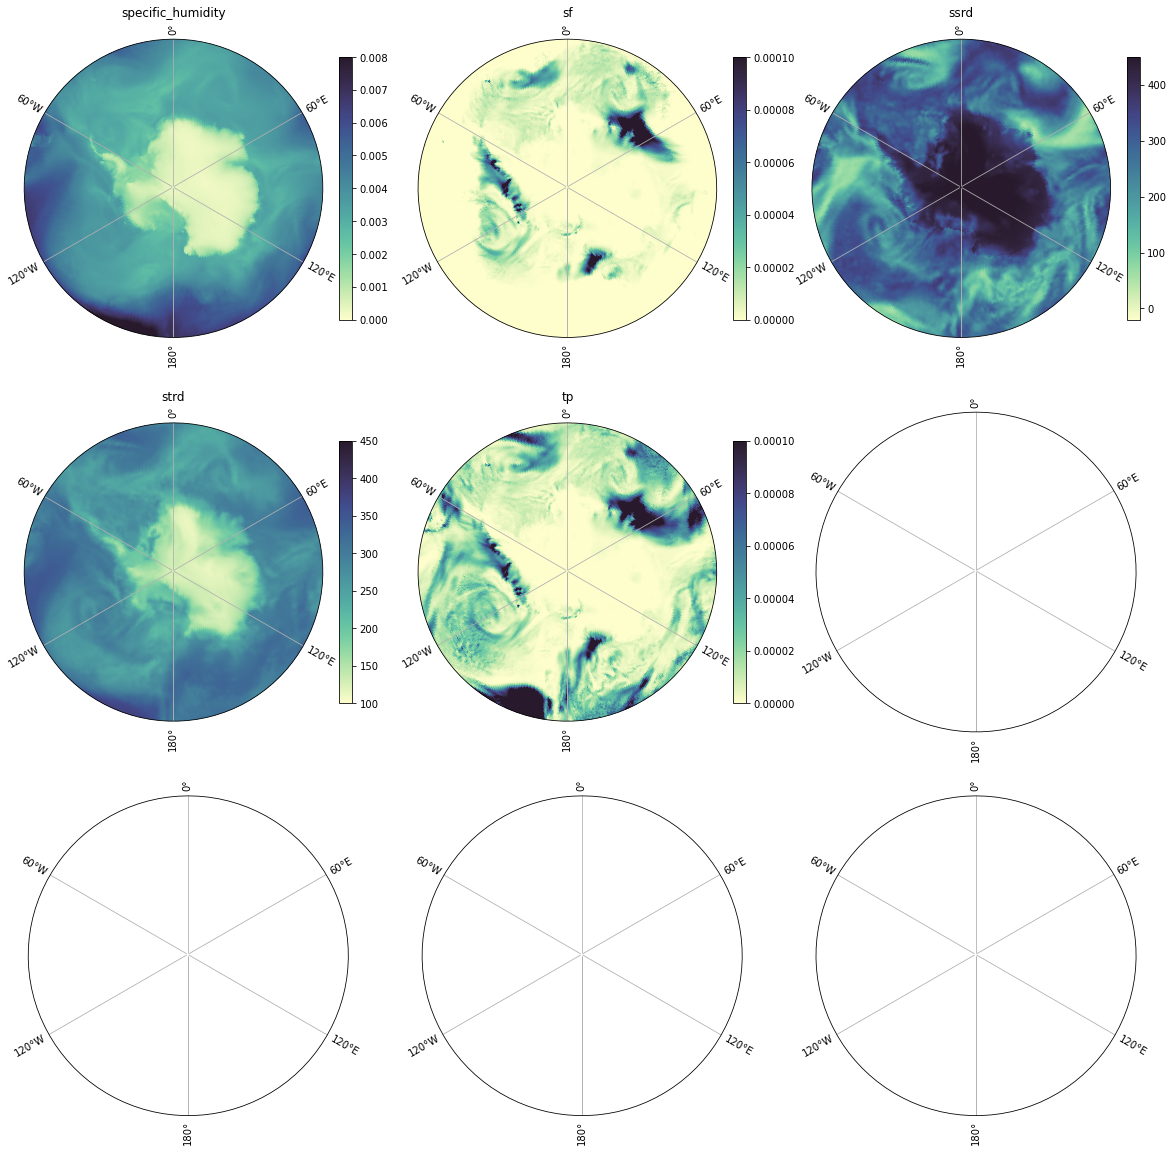

In [22]:
fig, ax = plt.subplots(3,3, figsize=(20,20), subplot_kw={'projection': ccrs.SouthPolarStereo()})

for axis in ax.ravel():
    axis.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    axis.set_boundary(map_circle, transform=axis.transAxes)
    gl = axis.gridlines(draw_labels=True, ylocs=[]);

for f, file in enumerate(files_ERA):
    ERA_dataset = xr.open_dataset(file).sel(latitude=slice(-49, -90)).isel(time=0)
    # print(sum(sum(np.isnan(ERA_dataset[list(ERA_dataset.keys())[0]].values))))
    # print(list(ERA_dataset.keys())[0])
    # print(ERA_dataset[list(ERA_dataset.keys())[0]].max(), 
    #       ERA_dataset[list(ERA_dataset.keys())[0]].min(), 
    #       ERA_dataset[list(ERA_dataset.keys())[0]].mean())
    
    plot_var(ax.ravel()[f], f, ERA_dataset)